### Step 1: Download the CRSP monthly dataset

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

pd.options.mode.chained_assignment = None

crsp = pd.read_csv('/Users/kailiao/Downloads/crsp.csv', dtype = object)

# change strings or floats to integers
for col in ['PERMNO','PERMCO']:
    crsp[col] = crsp[col].astype(int)

# change returns and prices to floats. If error, coerce to NaN
for col in ['PRC', 'RET', 'vwretd', 'SHROUT'] :
    crsp[col] = pd.to_numeric(crsp[col], errors='coerce')

# deal with negative price
crsp['PRC'] = crsp['PRC'].abs()

crsp['year']  = crsp['date'].str.slice(start=0, stop=4).astype(int)
crsp['month'] = crsp['date'].str.slice(start=4, stop=6).astype(int)
crsp['mrkcap'] = crsp['PRC'] * crsp['SHROUT']

### Step 2: Construct the sample (Using 1973 Period as an Example)

In [ ]:
period= 1973
crsp_1 = crsp[(crsp['year'] < period + 3) & (crsp['year'] >= period)]

def kill_nan_ret(df):
    if df['RET'].isnull().values.any():
        df['mrkcap'] = 0
    return df

crsp_1 = crsp_1.groupby('PERMNO').apply(kill_nan_ret)

# select the largest 500 firms
largest = list(crsp_1.groupby('PERMNO').first().nlargest(n=500, columns=['mrkcap']).reset_index().PERMNO)

### Step 2: Pre‐calculate firm level betas.

In [ ]:
crsp_2 = pd.DataFrame()
for firm in largest:
    crsp_temp = crsp_1[crsp_1['PERMNO'] == firm]
    model = smf.ols("RET ~ vwretd", data=crsp_temp)
    result = model.fit()
    crsp_temp['beta'] = result.params.vwretd
    crsp_2 = pd.concat([crsp_2, crsp_temp])

crsp_2 = crsp_2.merge(crsp_2.groupby('PERMNO').first().beta.rank().reset_index(), on='PERMNO')
crsp_2 = crsp_2.rename(columns={"beta_x" : "beta", "beta_y" : "beta_rank"})
crsp_2.head(5)

### Step 3: Construct portfolio betas

In [6]:
def port_weight(df):
    df['weight'] = df['mrkcap']/df['mrkcap'].sum()
    return df

def beta_port(df):
    model = smf.ols("portret ~ vwretd", data=df)
    result = model.fit()
    return result.params.vwretd

# generate portfolios

grids = [i for i in np.arange(10) * 50]
for grid in grids:
    crsp_2.loc[(crsp_2["beta_rank"] > grid)&(crsp_2["beta_rank"] <= grid + 50), 'port'] = np.floor(grid/50) + 1

crsp_2['weight'] = np.nan
crsp_2 = crsp_2.groupby(['port', 'date']).apply(port_weight)
# weighted return for the stock in a portfolio
crsp_2['portwret'] = crsp_2['RET'] * crsp_2['weight']

portfolios = pd.DataFrame(crsp_2.groupby(['port','date']).portwret.sum()).reset_index()
portfolios = portfolios.rename(columns={'portwret' : 'portret'})
portfolios = portfolios.merge(crsp_2[['date','vwretd']].drop_duplicates(), on='date')

port_beta = pd.DataFrame(portfolios.groupby('port').apply(beta_port)).reset_index().rename(columns={0 : 'beta_port'})
port_beta

,port,beta_port
0,1.0,0.482903
1,2.0,0.714655
2,3.0,0.829689
3,4.0,0.937254
4,5.0,1.029643
5,6.0,1.138358
6,7.0,1.213818
7,8.0,1.330404
8,9.0,1.508009
9,10.0,1.912798


### Step 4: Calculate buy‐and‐hold portfolio returns

In [8]:
crsp_t = crsp[(crsp['year'] < period + 8) & (crsp['year'] >= period + 3)]
# select the largest firm as in the training samples
crsp_t = crsp_t[crsp_t['PERMNO'].isin(largest)]
crsp_t = crsp_t.merge(crsp_2[['port', 'PERMNO']], on='PERMNO')
crsp_t = crsp_t.groupby(['PERMNO', 'date']).first().reset_index()

crsp_t['weight'] = np.nan
crsp_t = crsp_t.groupby(['port', 'date']).apply(port_weight)
# weighted return for the stock in a portfolio
crsp_t['portwret'] = crsp_t['RET'] * crsp_t['weight']

portfolios_t = pd.DataFrame(crsp_t.groupby(['port','date']).portwret.sum()).reset_index()
portfolios_t = portfolios_t.rename(columns={'portwret' : 'portret'})
portfolios_t = portfolios_t.merge(crsp_t[['date','vwretd']].drop_duplicates(), on='date')

port_ret_t = pd.DataFrame(portfolios_t.groupby('port').portret.mean()).reset_index()

port_ret_t

,port,portret
0,1.0,0.018180
1,2.0,0.019659
2,3.0,0.012988
3,4.0,0.017295
4,5.0,0.011786
5,6.0,0.017166
6,7.0,0.012082
7,8.0,0.013041
8,9.0,0.013561
9,10.0,0.016387


### Repeat Step 1 - 4 to For 8 Periods

In [13]:
periods = [1973 + i for i in np.arange(8) * 5]

BETAS = pd.DataFrame()
RETURNS = pd.DataFrame()

for period in periods:
    
    def kill_nan_ret(df):
        if df['RET'].isnull().values.any():
            df['mrkcap'] = 0
        return df

    def port_weight(df):
        df['weight'] = df['mrkcap']/df['mrkcap'].sum()
        return df

    def beta_port(df):
        model = smf.ols("portret ~ vwretd", data=df)
        result = model.fit()
        return result.params.vwretd
        

    crsp_1 = crsp[(crsp['year'] < period + 3) & (crsp['year'] >= period)]

    crsp_1 = crsp_1.groupby('PERMNO').apply(kill_nan_ret)

    # select the largest 500 firms
    largest = list(crsp_1.groupby('PERMNO').first().nlargest(n=500, columns=['mrkcap']).reset_index().PERMNO)

    crsp_2 = pd.DataFrame()
    for firm in largest:
        crsp_temp = crsp_1[crsp_1['PERMNO'] == firm]
        model = smf.ols("RET ~ vwretd", data=crsp_temp)
        result = model.fit()
        crsp_temp['beta'] = result.params.vwretd
        crsp_2 = pd.concat([crsp_2, crsp_temp])

    crsp_2 = crsp_2.merge(crsp_2.groupby('PERMNO').first().beta.rank().reset_index(), on='PERMNO')
    crsp_2 = crsp_2.rename(columns={"beta_x" : "beta", "beta_y" : "beta_rank"})

    # generate portfolios

    grids = [i for i in np.arange(10) * 50]
    for grid in grids:
        crsp_2.loc[(crsp_2["beta_rank"] > grid)&(crsp_2["beta_rank"] <= grid + 50), 'port'] = np.floor(grid/50) + 1

    crsp_2['weight'] = np.nan
    crsp_2 = crsp_2.groupby(['port', 'date']).apply(port_weight)
    # weighted return for the stock in a portfolio
    crsp_2['portwret'] = crsp_2['RET'] * crsp_2['weight']

    portfolios = pd.DataFrame(crsp_2.groupby(['port','date']).portwret.sum()).reset_index()
    portfolios = portfolios.rename(columns={'portwret' : 'portret'})
    portfolios = portfolios.merge(crsp_2[['date','vwretd']].drop_duplicates(), on='date')

    port_beta = pd.DataFrame(portfolios.groupby('port').apply(beta_port)).reset_index().rename(columns={0 : 'beta_port'})
    port_beta['period'] = period

    BETAS = pd.concat([BETAS, port_beta])


    crsp_t = crsp[(crsp['year'] < period + 8) & (crsp['year'] >= period + 3)]
    # select the largest firm as in the training samples
    crsp_t = crsp_t[crsp_t['PERMNO'].isin(largest)]
    crsp_t = crsp_t.merge(crsp_2[['port', 'PERMNO']], on='PERMNO')
    crsp_t = crsp_t.groupby(['PERMNO', 'date']).first().reset_index()

    crsp_t['weight'] = np.nan
    crsp_t = crsp_t.groupby(['port', 'date']).apply(port_weight)
    # weighted return for the stock in a portfolio
    crsp_t['portwret'] = crsp_t['RET'] * crsp_t['weight']

    portfolios_t = pd.DataFrame(crsp_t.groupby(['port','date']).portwret.sum()).reset_index()
    portfolios_t = portfolios_t.rename(columns={'portwret' : 'portret'})
    portfolios_t = portfolios_t.merge(crsp_t[['date','vwretd']].drop_duplicates(), on='date')

    port_ret_t = pd.DataFrame(portfolios_t.groupby('port').portret.mean()).reset_index()
    port_ret_t['period'] = period

    RETURNS = pd.concat([RETURNS, port_ret_t])

In [15]:
BETAS

,port,beta_port,period
0,1.0,0.482903,1973
1,2.0,0.714655,1973
2,3.0,0.829689,1973
3,4.0,0.937254,1973
4,5.0,1.029643,1973
...,...,...,...
5,6.0,1.130841,2008
6,7.0,1.263029,2008
7,8.0,1.475742,2008
8,9.0,1.655974,2008


In [22]:
RETURNS

,port,portret,period
0,1.0,0.018180,1973
1,2.0,0.019659,1973
2,3.0,0.012988,1973
3,4.0,0.017295,1973
4,5.0,0.011786,1973
...,...,...,...
5,6.0,0.013476,2008
6,7.0,0.011372,2008
7,8.0,0.008778,2008
8,9.0,0.008571,2008


### Test the CAMP

In [35]:
DATA = BETAS.merge(RETURNS, on=['port', 'period'])
model = smf.ols("portret ~ beta_port", data=DATA)
result = model.fit()

In [34]:
result.params

Intercept    0.013322
beta_port    0.000968
dtype: float64

<AxesSubplot:xlabel='beta_port', ylabel='portret'>

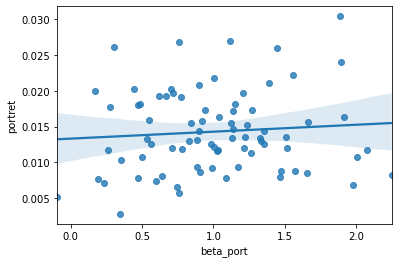

In [31]:
import seaborn as sns

sns.regplot(x='beta_port', y='portret', data=DATA)

### It is clear that the CAPM is rejected.